In [4]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


In [2]:
def CalcF(nx, y, dx=17/150):
    d = [(i*dx) for i in nx] # Distance from plate to plate
    d1, y1 = [i for ind, i in enumerate(d) if not ind % 2], [i for ind, i in enumerate(y) if not ind % 2]
    d2, y2 = [i for ind, i in enumerate(d) if ind % 2]    , [i for ind, i in enumerate(y) if ind % 2]
    xf, yf = np.average([d1, d2], axis=0), [(y2[i]-y1[i])/(d1[i]-d2[i]) for i in range(round(len(d)/2))] # Force from squeezing (-dx)
    return d, xf, yf

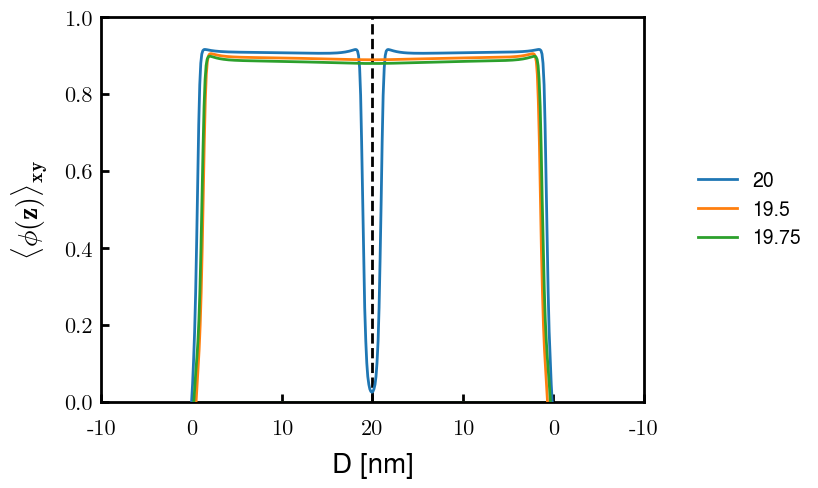

In [3]:
# SYSG Explore
labs = [20, 19.5, 19.75]
read_list = [GIT+'ph_a040d{:05.0f}.dat'.format(i*1000) for i in labs]
max_d = round(max(labs)) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 10 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

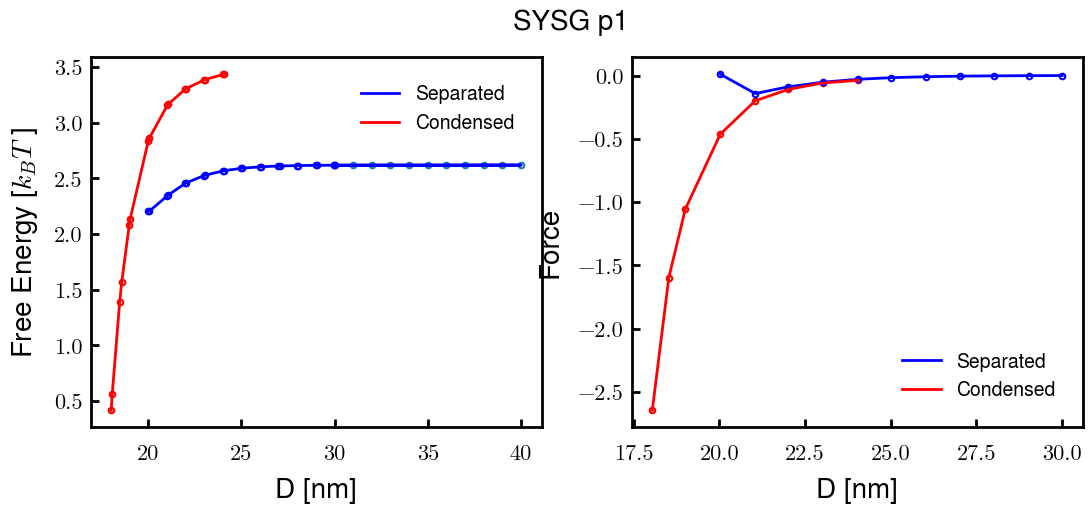

In [72]:
freeE = pd.read_csv(GIT+'p1_4030.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
d4030, y4030 = freeE.nx*17/150/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_c2520.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2520 = freeE.nx, freeE.freeE
dc2520, xc2520, fc2520 = CalcF(nx, yc2520)
freeE = pd.read_csv(GIT+'p1_s3020.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys3020 = freeE.nx, freeE.freeE
ds3020, xs3020, fs3020 = CalcF(nx, ys3020)
freeE = pd.read_csv(GIT+'p1_c1915.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc1915 = freeE.nx, freeE.freeE
dc1915, xc1915, fc1915 = CalcF(nx, yc1915)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(d4030, y4030, 'o', ms=4, markerfacecolor='none',  c='C0',  label='_4030')
    axs[0].plot(dc2520, yc2520, 'o', ms=4, markerfacecolor='none',  c='red',  label='_c2520')
    axs[0].plot(dc1915, yc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[0].plot(ds3020, ys3020, 'o', ms=4, markerfacecolor='none',  c='blue',  label='_s3020')
axs[0].plot([*d4030, *ds3020[::-1]], [*y4030, *ys3020[::-1]], c='blue', label='Separated')
axs[0].plot([*dc2520[::-1], *dc1915[::-1]], [*yc2520[::-1], *yc1915[::-1]], c='red', label='Condensed')

if 1:
    axs[1].plot(xc2520, fc2520, 'o', ms=4, markerfacecolor='none', c='red',  label='_c2520')
    axs[1].plot(xc1915, fc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[1].plot(xs3020, fs3020, 'o', ms=4, markerfacecolor='none', c='blue',  label='_s3020')
axs[1].plot([*xs3020[::-1]], [*fs3020[::-1]], c='blue', label='Separated')
axs[1].plot([*xc2520[::-1], *xc1915[::-1]], [*fc2520[::-1], *fc1915[::-1]], c='red', label='Condensed')

plt.suptitle('SYSG p1', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

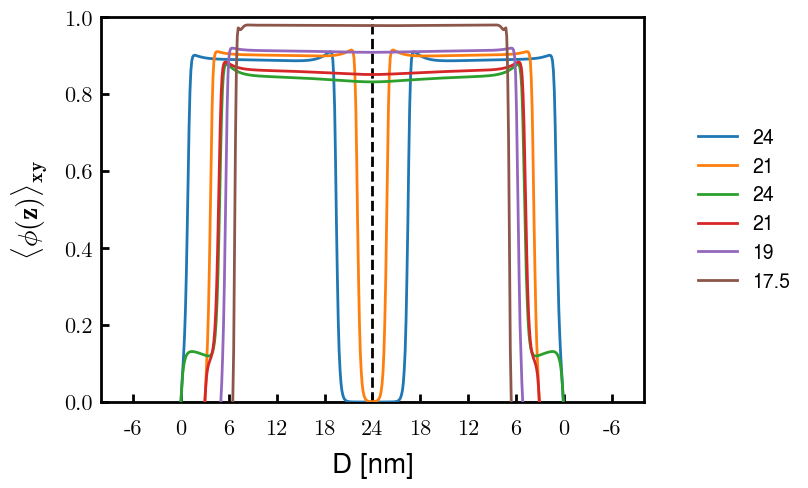

In [48]:
# SYSG 
labs = [24, 21]
read_list = [GIT+'ph_s3020d{:05.0f}.dat'.format(int(i*1000)) for i in labs]
labs2 = [24, 21]
read_list += [GIT+'ph_c2520d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2
labs2 = [19, 17.5]
read_list += [GIT+'ph_c1915d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
block_Ni = [[5]]*len(read_list)
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 6
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

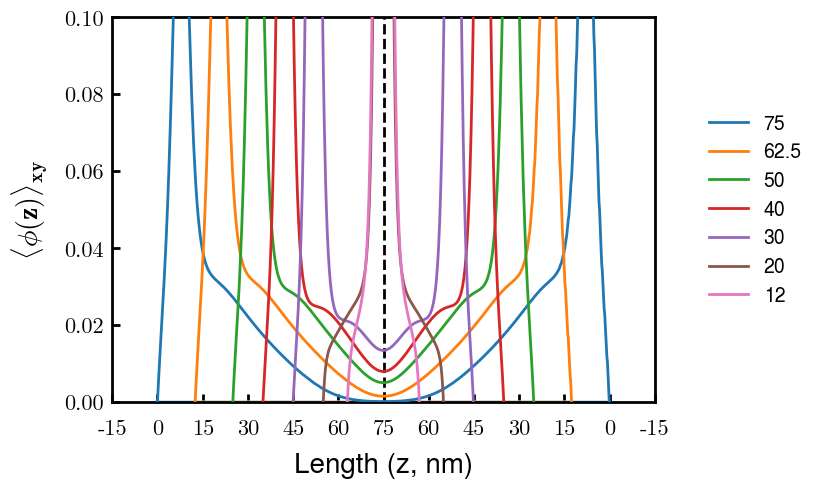

In [55]:
# NFH
labs = [75, 62.5, 50, 40]
read_list = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in labs]
labs2 = [30]
read_list += [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in labs2]
labs += labs2
labs2 = [20, 12]
read_list += [GIT+'ph_H04ed{:05d}.dat'.format(int(i*1000)) for i in labs2]
labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=0.80, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 15
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

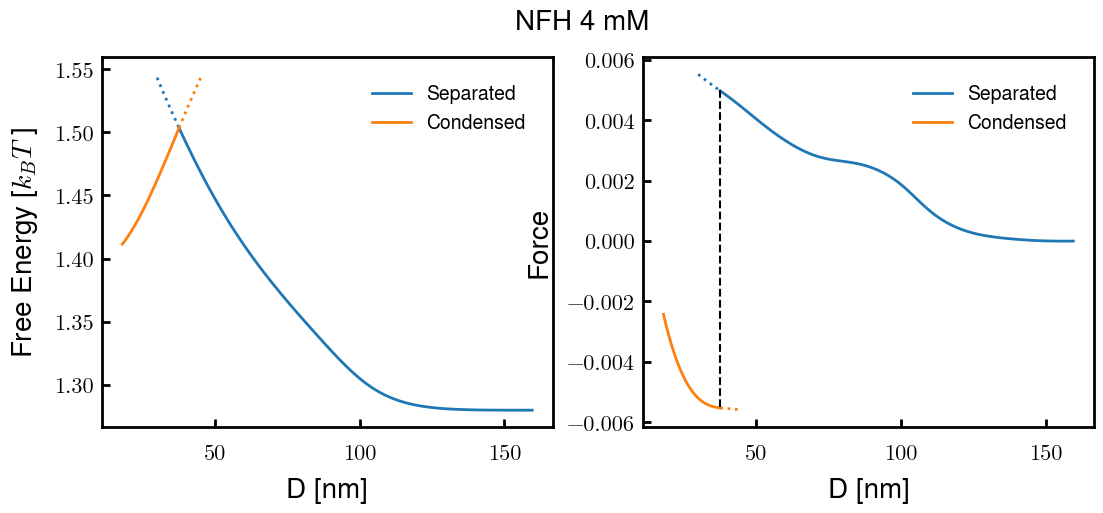

In [87]:
freeE = pd.read_csv(GIT+'NFH_04a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04 = freeE.nx, freeE.freeE
d04, x04, f04 = CalcF(nx, y04)
freeE = pd.read_csv(GIT+'NFH_04b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04b = freeE.nx, freeE.freeE
d04b, x04b, f04b = CalcF(nx, y04b)
freeE = pd.read_csv(GIT+'NFH_04c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04c = freeE.nx, freeE.freeE
d04c, x04c, f04c = CalcF(nx, y04c)
freeE = pd.read_csv(GIT+'NFH_04d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04d = freeE.nx, freeE.freeE
d04d, x04d, f04d = CalcF(nx, y04d)
freeE = pd.read_csv(GIT+'NFH_04e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04e = freeE.nx, freeE.freeE
d04e, x04e, f04e = CalcF(nx, y04e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d04, y04,   **kw, label='_H04a')
    axs[0].plot(d04b, y04b, **kw, label='_H04b')
    axs[0].plot(d04c, y04c, **kw, label='_H04c')
    axs[0].plot(d04d[:4], y04d[:4], **kw, label='_H04d')
    axs[0].plot(d04e, y04e, **kw, label='_H04e')
tosortd, tosorty = [*d04, *d04b, *d04c], [*y04, *y04b, *y04c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d04d[:6], *d04e], [*y04d[:6], *y04e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04c = UnivariateSpline(XX, YY)

if 0: # 1 to plot, 0 to not
    axs[1].plot(x04, f04,   **kw, label='_H04a')
    axs[1].plot(x04b, f04b, **kw, label='_H04b')
    axs[1].plot(x04c, f04c, **kw, label='_H04c')
    axs[1].plot(x04d[:4], f04d[:4], **kw, label='_H04d')
    axs[1].plot(x04e, f04e, **kw, label='_H04e')
tosortx, tosortf = [*x04, *x04b, *x04c], [*f04, *f04b, *f04c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x04d[:3], *x04e], [*f04d[:3], *f04e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_04s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_04c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_04c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_04s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_04c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_04c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 4 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

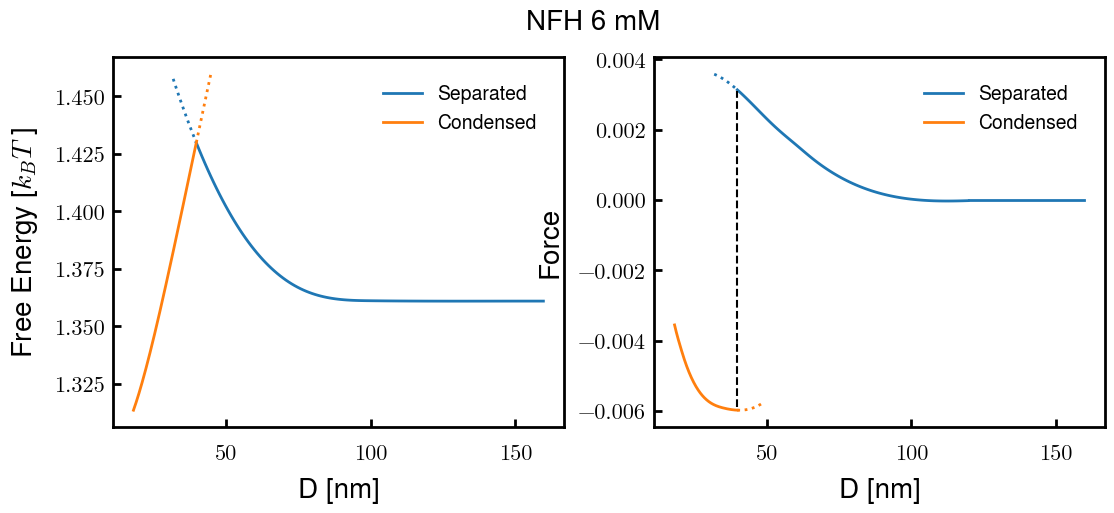

In [93]:
freeE = pd.read_csv(GIT+'NFH_06a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06a = freeE.nx, freeE.freeE
d06a, x06a, f06a = CalcF(nx, y06a)
freeE = pd.read_csv(GIT+'NFH_06b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06b = freeE.nx, freeE.freeE
d06b, x06b, f06b = CalcF(nx, y06b)
freeE = pd.read_csv(GIT+'NFH_06c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06c = freeE.nx, freeE.freeE
d06c, x06c, f06c = CalcF(nx, y06c)
freeE = pd.read_csv(GIT+'NFH_06d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06d = freeE.nx, freeE.freeE
d06d, x06d, f06d = CalcF(nx, y06d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d06a, y06a, **kw, label='_H06a')
    axs[0].plot(d06b, y06b, **kw, label='_H06b')
    axs[0].plot(d06c, y06c, **kw, label='_H06c')
    axs[0].plot(d06d, y06d, **kw, label='_H06d')
tosortx, tosortf = [*d06a, *d06b, *d06c[-16:]], [*y06a, *y06b, *y06c[-16:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d06c[:-16], *d06d], [*y06c[:-16], *y06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06c = UnivariateSpline(XX, YY, s=8e-8)
# axs[0].plot([*d06c[-16:], *d06a, *d06b], [*y06c[-16:], *y06a, *y06b], c='C0')
# axs[0].plot([*d06c[:-16], *d06d], [*y06c[:-16], *y06d], c='C1')

if 0: 
    axs[1].plot(x06a, f06a, **kw, label='_F06a')
    axs[1].plot(x06b, f06b, **kw, label='_F06b')
    axs[1].plot(x06c, f06c, **kw, label='_F06c')
    axs[1].plot(x06d, f06d, **kw, label='_F06d')
tosortx, tosortf = [*x06a[4:], *x06b], [*f06a[4:], *f06b]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06s = UnivariateSpline(XX, YY, s=2e-08)
tosortx, tosortf = [*x06c[4:-8], *x06d], [*f06c[4:-8], *f06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06c = UnivariateSpline(XX, YY, s=1e-08)
# axs[1].plot([*x06c[-8:], *x06a, *x06b], [*f06c[-8:], *f06a, *f06b], c='C0')
# axs[1].plot([*x06c[:-8], *x06d], [*f06c[:-8], *f06d], c='C1')

xx = 39.735
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_06s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_06c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 120), F_06s(np.arange(xx, 120)), c='C0', label='Separated') 
axs[1].plot(np.arange(120, 161, 20), [0]*3, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_06c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0031],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 6 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

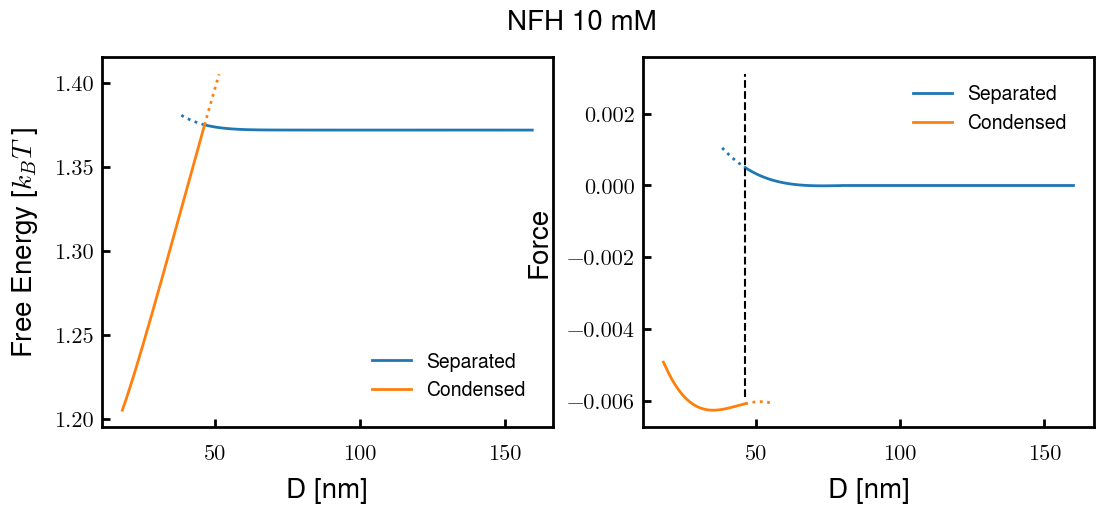

In [94]:
freeE = pd.read_csv(GIT+'NFH_10a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10a = freeE.nx, freeE.freeE
d10a, x10a, f10a = CalcF(nx, y10a)
freeE = pd.read_csv(GIT+'NFH_10b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10b = freeE.nx, freeE.freeE
d10b, x10b, f10b = CalcF(nx, y10b)
freeE = pd.read_csv(GIT+'NFH_10c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10c = freeE.nx, freeE.freeE
d10c, x10c, f10c = CalcF(nx, y10c)
freeE = pd.read_csv(GIT+'NFH_10d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10d = freeE.nx, freeE.freeE
d10d, x10d, f10d = CalcF(nx, y10d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d10a, y10a, **kw, label='_H10a')
    axs[0].plot(d10b, y10b, **kw, label='_H10b')
    axs[0].plot(d10c, y10c, **kw, label='_H10c')
    axs[0].plot(d10d, y10d, **kw, label='_H10d')
tosortx, tosortf = [*d10a, *d10b, *d10c[28:]], [*y10a, *y10b, *y10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d10c[:26], *d10d[:-2]], [*y10c[:26], *y10d[:-2]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10c = UnivariateSpline(XX, YY, s=8e-8)

if 0: 
    axs[1].plot(x10a, f10a, **kw, label='_F10a')
    axs[1].plot(x10b, f10b, **kw, label='_F10b')
    axs[1].plot(x10c[:13], f10c[:13], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10c[15:], f10c[15:], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10d, f10d, **kw, label='_F10d')
tosortx, tosortf = [*x10a, *x10b, *x10c[28:]], [*f10a, *f10b, *f10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x10c[:13], *x10d], [*f10c[:13], *f10d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10c = UnivariateSpline(XX, YY, s=8e-08)

xx = 46.35
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_10s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_10c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()
# axs[0].set_xlim(46, 47)
# axs[0].set_ylim(1.36, 1.38)

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 80), F_10s(np.arange(xx, 80)), c='C0', label='Separated') 
axs[1].plot(np.arange(80, 161, 20), [0]*5, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_10c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0031],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 10 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

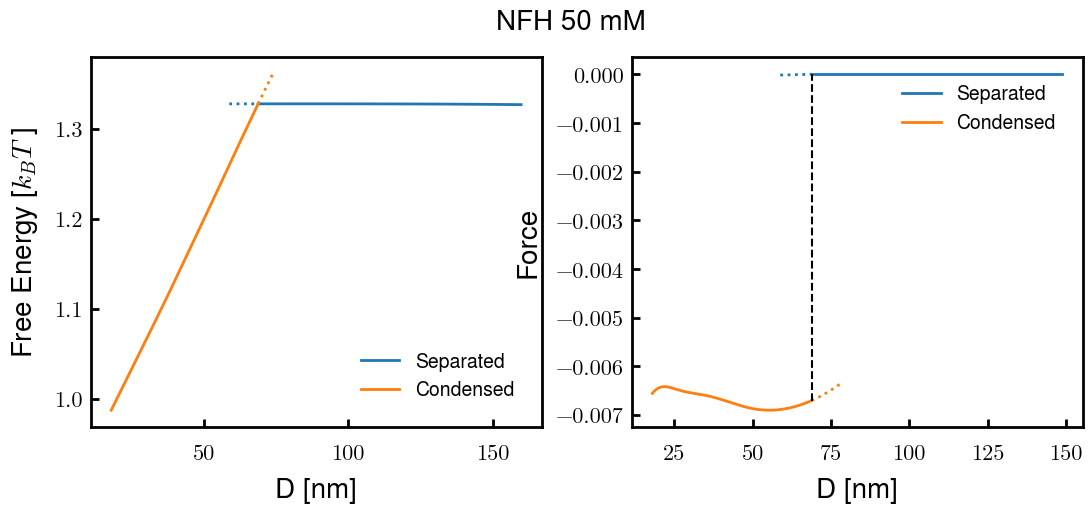

In [262]:
freeE = pd.read_csv(GIT+'NFH_50s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x50s, y50s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_50c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x50c, y50c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_50c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x50c2, y50c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50c = UnivariateSpline(XX, YY, s=1e-08)
# axs[0].plot(ds, ys, c='C0', label='Separated')
# axs[0].plot([*dc, *dc2], [*yc, *yc2], c='C1', label='Condensed')

if 0: 
    axs[1].plot(x50s, y50s, **kw, label='_NFHs')
    axs[1].plot(x50c[5:], y50c[5:], **kw, label='_NFHc')
    axs[1].plot(x50c2, y50c2, **kw, label='_NFHc')
tosortx, tosortf = x50s, y50s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x50c[5:], *x50c2], [*y50c[5:], *y50c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50c = UnivariateSpline(XX, YY, s=6e-08)
# axs[1].plot(x50s, y50s, c='C0', label='Separated')
# axs[1].plot([*x50c, *x50c2], [*y50c, *y50c2], c='C1', label='Condensed')

xx = 68.85
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_50s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_50c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_50c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0067, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 50 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

Success: 529 == 529.
Actual Lx: 59.95


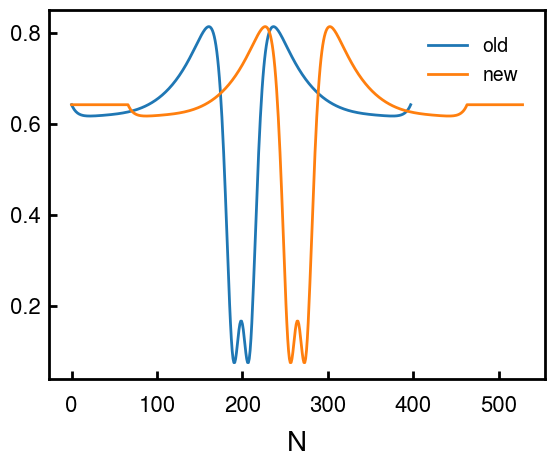

In [274]:
## Adjust D (half-space)
filename = 'W_a020d22560.dat' 
fill_mid = False # Add to mid (Sep) if True, add to ends (Con) if False
dx = 17/150
new_Lx = 60
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
old_N = len(df.index)

if N >= old_N: 
    if fill_mid == True:
        mid = round(old_N/2)
        rem = df.iloc[mid,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-2*mid)], columns=names)
        new = pd.concat([df.iloc[:round(old_N/2)], rem, df.iloc[-round(old_N/2):]], ignore_index=True)
    else: 
        end = 0 
        rem = df.iloc[end,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-old_N)], columns=names)
        new = pd.concat([rem.iloc[:round((N-old_N)/2)], df, rem[round((N-old_N)/2):]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    print('Actual Lx: {:.2f}'.format(N*dx))
    new.to_csv('./imgs/W_in{}.dat'.format(round(new_Lx)), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True: 
    plt.plot(df.w1, label='old')
    plt.plot(new.w1, label='new')
    plt.legend()
    plt.xlabel('N')

In [225]:
print(np.ceil(1.5))
print(np.floor(1.5))

2.0
1.0


Success: 706 == 706.


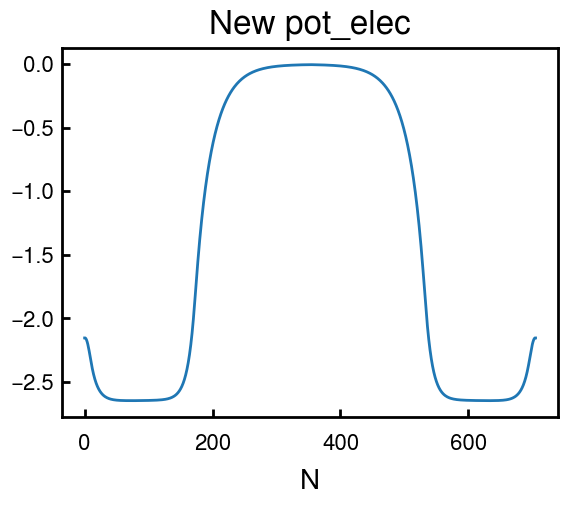

In [87]:
## SINGLE --> DOUBLE WA
filename = 'W_a040c010_x200s002.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 80
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
# display(df)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True:
    plt.plot(new.pot_elec)
    plt.title('New pot_elec')
    plt.xlabel('N')

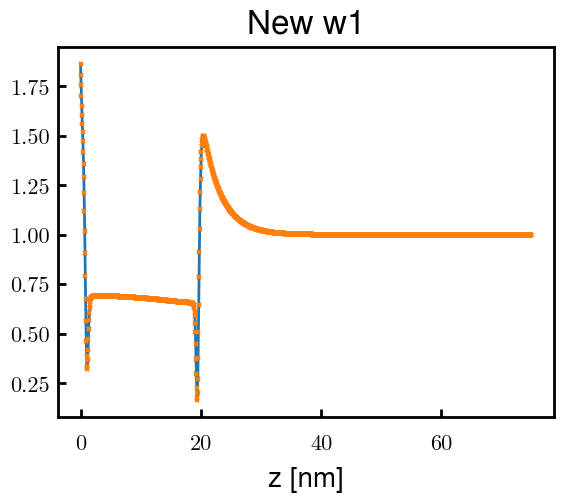

In [140]:
## SINGLE dx1 --> dx2
from scipy.interpolate import CubicSpline
filename = 'W_a040c010_x200s002.dat' #Nx = 75, dx = 17.0/150
dx1 = 17.0/150 # Old
dx2 = 0.05 # New
Lx = 75
Nx1, Nx2 = round(Lx/dx1), round(Lx/dx2)

x1 = np.arange(0, Lx, dx1)
x2 = np.arange(0, Lx, dx2)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if True: 
    test_frame = df.w1
    cs = CubicSpline(x1, test_frame)
    plt.plot(x1, test_frame)
    plt.plot(x2, cs(x2), 'x', markerfacecolor='w', ms=3)

    plt.title('New w1')
    plt.xlabel('z [nm]')
    tjy.ticks()
    plt.show()

A = []
for i in [1, 2, 3, 4, 5, 7, 8, 9]:
    cs = CubicSpline(x1, df.iloc[:, i])
    A = [*A, cs(x2)]
fill = np.array(['[']*(Nx2))
A = [fill, A[0], A[1], A[2], A[3], A[4], fill, A[5], A[6], A[7]]
new = pd.DataFrame(A).transpose()
new.to_csv('./imgs/W_dx{}.dat'.format(dx2*100), sep='\t', float_format='%10.5e', header=False, index=False)